In [58]:
import pandas as pd
from datasets import load_dataset
import numpy as np
import seaborn as sns
import re
from functools import reduce
from collections import Counter

In [3]:
train_dataset = load_dataset("health_fact", split="train")
val_dataset = load_dataset("health_fact", split="validation")

Using custom data configuration default
Reusing dataset health_fact (C:\Users\Asus\.cache\huggingface\datasets\health_fact\default\1.1.0\99503637e4255bd805f84d57031c18fe4dd88298f00299d56c94fc59ed68ec19)
Using custom data configuration default
Reusing dataset health_fact (C:\Users\Asus\.cache\huggingface\datasets\health_fact\default\1.1.0\99503637e4255bd805f84d57031c18fe4dd88298f00299d56c94fc59ed68ec19)


In [22]:
train_df = pd.DataFrame(train_dataset)
train_df

,claim_id,claim,date_published,explanation,fact_checkers,main_text,sources,label,subjects
0,15661,"""The money the Clinton Foundation took from fr...","April 26, 2015","""Gingrich said the Clinton Foundation """"took m...",Katie Sanders,"""Hillary Clinton is in the political crosshair...",https://www.wsj.com/articles/clinton-foundatio...,0,"Foreign Policy, PunditFact, Newt Gingrich,"
1,9893,Annual Mammograms May Have More False-Positives,"October 18, 2011",This article reports on the results of a study...,,While the financial costs of screening mammogr...,,1,"Screening,WebMD,women's health"
2,11358,SBRT Offers Prostate Cancer Patients High Canc...,"September 28, 2016",This news release describes five-year outcomes...,"Mary Chris Jaklevic,Steven J. Atlas, MD, MPH,K...",The news release quotes lead researcher Robert...,https://www.healthnewsreview.org/wp-content/up...,1,"Association/Society news release,Cancer"
3,10166,"Study: Vaccine for Breast, Ovarian Cancer Has ...","November 8, 2011","While the story does many things well, the ove...",,"The story does discuss costs, but the framing ...",http://clinicaltrials.gov/ct2/results?term=can...,2,"Cancer,WebMD,women's health"
4,11276,Some appendicitis cases may not require ’emerg...,"September 20, 2010",We really don’t understand why only a handful ...,,"""Although the story didn’t cite the cost of ap...",,2,
...,...,...,...,...,...,...,...,...,...
9827,35948,The Sturgis motorcycle rally in 2020 resulted ...,"September 10, 2020","They want to know if mass-events (protests, co...",Dan Evon,"In September 2020, social media was abuzz over...",,3,"Politics Medical, COVID-19"
9828,401,AstraZeneca's infant respiratory drug prioriti...,"September 25, 1995",Britain’s AstraZeneca said a potential medicin...,,The “Breakthrough Therapy” and “Prime” designa...,,2,Health News
9829,2023,Testicular cancer deaths double with after 40 ...,"February 10, 2011",Men diagnosed with testicular cancer at 40 yea...,,This was true even when initial treatment and ...,http://bit.ly/fGNEw9,2,Health News
9830,38118,The FDA published “conclusive proof” that the...,"November 22, 2017",FDA Confirms DTaP Vaccine Causes Autism in Nov...,Rich Buhler & Staff,The FDA hasn’t confirmed a link between DTaP v...,https://www.truthorfiction.com/marshall-kamena...,0,Medical


claim and main_text columns should definitely be in the inputs since the model is predicting claim truthfullness based on main_text.

In [7]:
train_df['label'].value_counts()

 2    5078
 0    3001
 1    1434
 3     291
-1      28
Name: label, dtype: int64

In [8]:
train_df[train_df['label']==-1]

,claim_id,claim,date_published,explanation,fact_checkers,main_text,sources,label,subjects
1312,39819,A forwarded email that cautions veterans abou...,"March 17, 2015",Veterans can lose their weapons permit if they...,"""",,,-1,
1313,Rich Buhler & Staff,,,,,,,-1,
1314,"""",This one is fiction. A spokesperson at the V...,https://www.truthorfiction.com/category/milita...,false,"Military, Warnings",,,-1,
2151,18462,"""In barely four years in office, five jihadist...","April 26, 2013","""Cotton said, """"In barely four years in office...",Louis Jacobson,"""During a House floor speech just days after t...",,-1,
2152,"""",https://www.politifact.com/truth-o-meter/state...,false,"National, Terrorism, Tom Cotton,",,,,-1,
2478,39981,A message with what the email says is...,"March 17, 2015",14-year-old boy who had a scary experience wit...,"""",,,-1,
2479,Rich Buhler & Staff,,,,,,,-1,
2480,"""",This Dear Abby article was published i...,"https://www.truthorfiction.com/odennell/, http...",unproven,"Food / Drink, Warnings",,,-1,
2650,40188,This is a forwarded article that alleges th...,"March 17, 2015",Planned Parenthood Brochures Distributed to Gi...,"""",,,-1,
2651,Rich Buhler & Staff,,,,,,,-1,


Rows with label -1 seem to be corrupted, so I drop them

In [31]:
train_df = train_df[train_df['label']!=-1]

In [10]:
train_df

,claim_id,claim,date_published,explanation,fact_checkers,main_text,sources,label,subjects
0,15661,"""The money the Clinton Foundation took from fr...","April 26, 2015","""Gingrich said the Clinton Foundation """"took m...",Katie Sanders,"""Hillary Clinton is in the political crosshair...",https://www.wsj.com/articles/clinton-foundatio...,0,"Foreign Policy, PunditFact, Newt Gingrich,"
1,9893,Annual Mammograms May Have More False-Positives,"October 18, 2011",This article reports on the results of a study...,,While the financial costs of screening mammogr...,,1,"Screening,WebMD,women's health"
2,11358,SBRT Offers Prostate Cancer Patients High Canc...,"September 28, 2016",This news release describes five-year outcomes...,"Mary Chris Jaklevic,Steven J. Atlas, MD, MPH,K...",The news release quotes lead researcher Robert...,https://www.healthnewsreview.org/wp-content/up...,1,"Association/Society news release,Cancer"
3,10166,"Study: Vaccine for Breast, Ovarian Cancer Has ...","November 8, 2011","While the story does many things well, the ove...",,"The story does discuss costs, but the framing ...",http://clinicaltrials.gov/ct2/results?term=can...,2,"Cancer,WebMD,women's health"
4,11276,Some appendicitis cases may not require ’emerg...,"September 20, 2010",We really don’t understand why only a handful ...,,"""Although the story didn’t cite the cost of ap...",,2,
...,...,...,...,...,...,...,...,...,...
9827,35948,The Sturgis motorcycle rally in 2020 resulted ...,"September 10, 2020","They want to know if mass-events (protests, co...",Dan Evon,"In September 2020, social media was abuzz over...",,3,"Politics Medical, COVID-19"
9828,401,AstraZeneca's infant respiratory drug prioriti...,"September 25, 1995",Britain’s AstraZeneca said a potential medicin...,,The “Breakthrough Therapy” and “Prime” designa...,,2,Health News
9829,2023,Testicular cancer deaths double with after 40 ...,"February 10, 2011",Men diagnosed with testicular cancer at 40 yea...,,This was true even when initial treatment and ...,http://bit.ly/fGNEw9,2,Health News
9830,38118,The FDA published “conclusive proof” that the...,"November 22, 2017",FDA Confirms DTaP Vaccine Causes Autism in Nov...,Rich Buhler & Staff,The FDA hasn’t confirmed a link between DTaP v...,https://www.truthorfiction.com/marshall-kamena...,0,Medical


## claim_id

In [16]:
np.array(train_df['claim_id']).astype(np.int)

C:\Users\Asus\AppData\Local\Temp\ipykernel_26976\2626005756.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.array(train_df['claim_id']).astype(np.int)


array([15661,  9893, 11358, ...,  2023, 38118, 24750])

C:\Users\Asus\AppData\Local\Temp\ipykernel_26976\2069742450.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.violinplot(y=np.array(train_df['claim_id']).astype(np.int), x=train_df['label'])


<AxesSubplot:xlabel='label'>

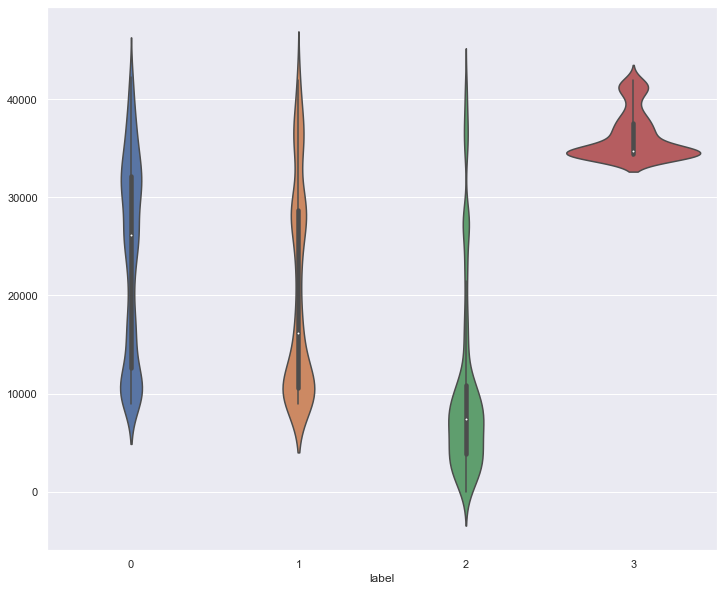

In [21]:
sns.set(rc={'figure.figsize':(12,10)})
sns.violinplot(y=np.array(train_df['claim_id']).astype(np.int), x=train_df['label'])

Claim ids are distributed differently for different labels. If we include them into training data, model may cheat by using them. Also it doens't make sense to use them as input since deployed model will see new unique ids

## claim and main_text

In [120]:
train_df['claim_lengths'] = train_df.apply(lambda row: len(row['claim']), axis=1)
train_df['main_text_lens'] = train_df.apply(lambda row: len(row['main_text']), axis=1)
train_df['claim_to_text_ratio'] = train_df.apply(lambda row: len(row['claim']) / len(row['main_text']), axis=1)

C:\Users\Asus\AppData\Local\Temp\ipykernel_26976\2242930425.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['claim_lengths'] = train_df.apply(lambda row: len(row['claim']), axis=1)
C:\Users\Asus\AppData\Local\Temp\ipykernel_26976\2242930425.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['main_text_lens'] = train_df.apply(lambda row: len(row['main_text']), axis=1)
C:\Users\Asus\AppData\Local\Temp\ipykernel_26976\2242930425.py:3: SettingWithCopyWarning: 
A value is trying to be set 

In [121]:
train_df[['claim_lengths', 'main_text_lens', 'claim_to_text_ratio']].describe()

,claim_lengths,main_text_lens,claim_to_text_ratio
count,9804.000000,9804.000000,9804.000000
mean,85.687475,4376.948388,0.029072
std,45.633115,3125.483647,0.029832
min,26.000000,401.000000,0.001522
25%,57.000000,2330.000000,0.013886
50%,68.000000,3716.500000,0.020455
75%,105.000000,5612.000000,0.032596
max,491.000000,41731.000000,0.823096


C:\Users\Asus\AppData\Local\Temp\ipykernel_26976\50037750.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.violinplot(y=np.array(train_df['claim_lengths']).astype(np.int), x=train_df['label'])


<AxesSubplot:xlabel='label'>

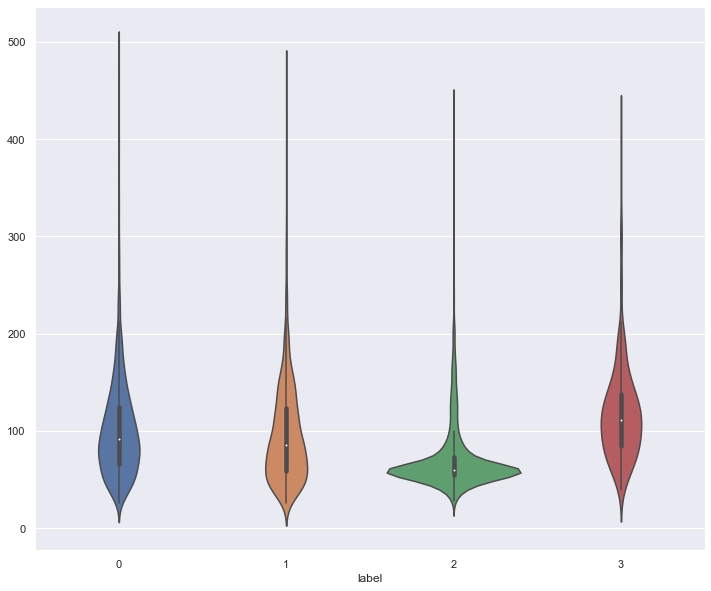

In [34]:
sns.violinplot(x=train_df['label'], y=np.array(train_df['claim_lengths']).astype(np.int))

C:\Users\Asus\AppData\Local\Temp\ipykernel_26976\3282190588.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.violinplot(y=np.array(train_df['main_text_lens']).astype(np.int), x=train_df['label'])


<AxesSubplot:xlabel='label'>

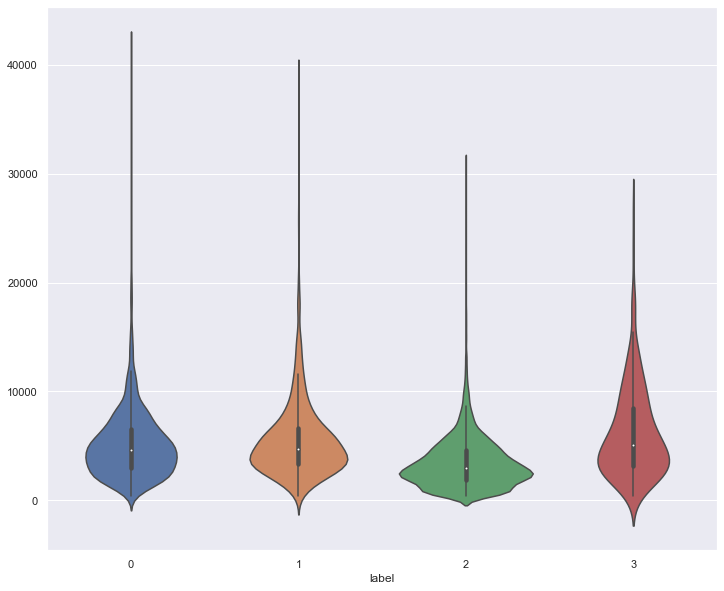

In [35]:
sns.violinplot(x=train_df['label'], y=np.array(train_df['main_text_lens']).astype(np.int))

C:\Users\Asus\AppData\Local\Temp\ipykernel_26976\1877658343.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.violinplot(y=np.array(train_df['claim_to_text_ratio']).astype(np.float), x=train_df['label'])


<AxesSubplot:xlabel='label'>

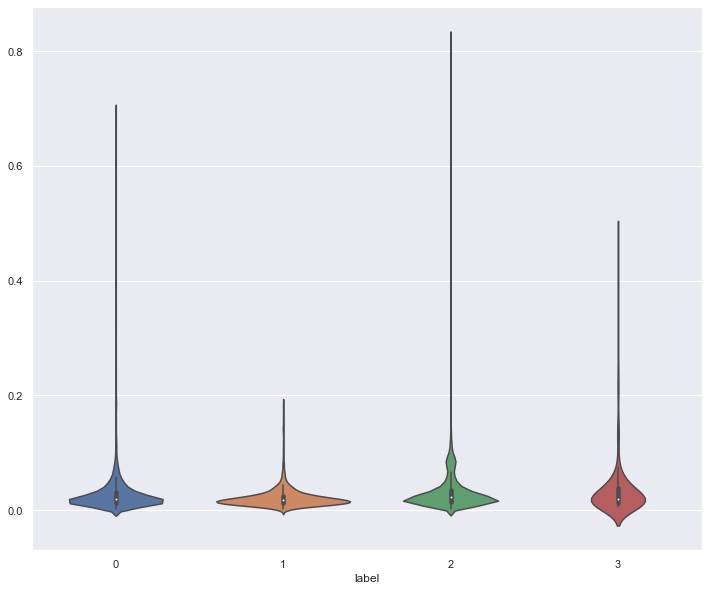

In [123]:
sns.violinplot(x=train_df['label'], y=np.array(train_df['claim_to_text_ratio']).astype(np.float))

claim and main_text lengths are mostly similar across labels, but for label 2 (truth) both claim and main_text tend to be shorter

## date_published

In [38]:
train_df['date_published'].value_counts()

                     1929
March 17, 2015        109
March 20, 2020         33
March 30, 2020         33
April 9, 2020          32
                     ... 
September 7, 2019       1
November 25, 2007       1
June 15, 2020           1
October 3, 2006         1
March 23, 2009          1
Name: date_published, Length: 3235, dtype: int64

Large chunk of the data doesn't have date_published value, also March 17, 2015 has anomalous number of occurences. Let's investigate

In [44]:
train_df[train_df['date_published'] == 'March 17, 2015']

,claim_id,claim,date_published,explanation,fact_checkers,main_text,sources,label,subjects,claim_lengths,main_text_lens
164,40516,The email says that Simon and Schuster has a...,"March 17, 2015",New CD-ROM computer game features panty raids,Rich Buhler & Staff,"According to Simon and Schuster’s website, it’...",https://www.reddit.com/submit?url=https%3A%2F%...,2,"Computers, Warnings",317,2385
232,40077,A prayer request for a 4-year old girl who ha...,"March 17, 2015",Pray for 4-year old Madison who is cancer,Rich Buhler & Staff,TruthOrFiction.com contacted Madison’s great-a...,https://twitter.com/intent/tweet?text=Pray+for...,2,"Pleas, Prayers",268,638
296,39599,The story of an 11-year-old girl who has had ...,"March 17, 2015",Young girl with serious health problems from W...,Rich Buhler & Staff,"There is controversy over rBST, which stands ...",https://www.truthorfiction.com/category/animal...,3,"Animals, Food / Drink, Health / Medical, House...",413,1963
327,37083,Fruits and vegetables from other countries are...,"March 17, 2015",Were Blood Oranges from Libya Injected with HIV?,Rich Buhler & Staff,A popular rumor about oranges or bananas from ...,https://danitzh.deviantart.com/art/Blood-Orang...,0,"Disinformation, Fact Checks, Health / Medical,...",107,2847
433,39784,An abandoned “ghost ship” full of Ebola-infe...,"March 17, 2015",Ghost Ship Full of Ebola Rats Headed Toward U....,Rich Buhler & Staff,A fake news website started the false eRumor t...,https://www.independent.co.uk/news/uk/home-new...,0,9/11 Attack on America,87,2231
...,...,...,...,...,...,...,...,...,...,...,...
9428,40156,There are various versions of this on...,"March 17, 2015",Retired subway and bus driver Stanley De Freit...,Rich Buhler & Staff,“Life became unbearable. From the time I got u...,https://www.truthorfiction.com/category/medica...,2,"Medical, Warnings",281,5210
9492,39476,A television reporter in Detroit investigated...,"March 17, 2015",High mark-ups on prices of generic drugs,Rich Buhler & Staff,There seems to have been a rash of TV reports ...,https://www.truthorfiction.com/category/househ...,2,Household,374,2288
9544,40088,A Halloween warning not to eat Sherwood brand...,"March 17, 2015",Melamine Scare In Milk Chocolate Coins,Rich Buhler & Staff,This warning is true in Canada only. October...,https://twitter.com/intent/tweet?text=Melamine...,2,"Food / Drink, Warnings",159,1501
9718,40285,An email petition nominating Officer Danita M...,"March 17, 2015",Officer Danita Marsh Petition for an Extreme M...,Rich Buhler & Staff,"According to a Nashville Government Web Site,...",https://www.truthorfiction.com/category/crime-...,2,"Crime / Police, Pleas",258,2012


In [45]:
train_df[train_df['date_published'] == 'March 17, 2015']['fact_checkers'].value_counts()

  Rich Buhler & Staff           96
Rich Buhler & Staff              6
"Rich Buhler & Staff"            2
Alex Dobuzinskis, Andrew Hay     1
Aditya Kalra                     1
 Rich Buhler & Staff             1
Niklas Pollard, Kate Kelland     1
                                 1
Name: fact_checkers, dtype: int64

In [47]:
train_df[train_df['date_published'] == 'March 17, 2015']['label'].value_counts()

2    43
0    43
1    12
3    11
Name: label, dtype: int64

Almost all of the entries for that date have the same fact checkers. The labels are distributed similarly to the whole dataset

In [48]:
train_df[train_df['date_published'] == '']

,claim_id,claim,date_published,explanation,fact_checkers,main_text,sources,label,subjects,claim_lengths,main_text_lens
11,5793,Democrats hoping to flip House not just trash-...,,Democrats hoping to flip enough seats to regai...,Steve Leblanc,"Those candidates include Lauren Underwood, a 3...",,2,"Access to health care, Health, Politics, North...",60,4924
15,30635,The train carrying GOP members of Congress to ...,,"Sites like YourNewsWire, Gateway Pundit and In...",Bethania Palma,"On 31 January 2018, an Amtrak train carrying R...",,0,"Politics, deep state, gateway pundit, infowars",103,5695
16,2981,Sex tech from women-led startups pops up at CE...,,Sex tech is gracing the CES gadget show in Las...,Rachel Lerman,CES is allowing space for sex tech companies a...,"/13ff3df5aa6b428db431a7f50c4b7c5d,/cf15491db21...",2,"Technology, Consumer Electronics Show, General...",60,5003
20,3077,Officials alert health care providers of HIV s...,,Massachusetts officials alerted health care pr...,,Officials discovered that there were 182 intra...,https://www.bostonglobe.com/metro/2020/01/08/s...,2,"Boston, General News, Public health, Lowell, M...",51,1048
26,7453,Brazil cities lurch to lockdowns amid virus cr...,,Faced with overwhelmed hospitals and surging c...,David Biller And Mauricio Savarese,The movements of Brazilians have been complete...,,2,"Brazil, Rio de Janeiro, AP Top News, Health, G...",61,6392
...,...,...,...,...,...,...,...,...,...,...,...
9804,5853,US sexually transmitted disease hit another high.,,Health officials are reporting another record ...,Mike Stobbe,More than 2 million new cases of chlamydia (kl...,https://www.cdc.gov/std/stats16/default.htm,2,"Health, Sexually transmitted diseases, Chlamyd...",49,771
9805,6691,Apollo 11 at 50: Celebrating first steps on an...,,"A half-century ago, in the middle of a mean ye...",Marcia Dunn,Hundreds of millions tuned in to radios or wat...,https://www.ap.org/press-releases/2018/ap-hhmi...,2,"Buzz Aldrin, Neil Armstrong, AP Top News, Apol...",58,10182
9812,7529,Virus death rate still uncertain as mild cases...,,How deadly is the coronavirus that exploded fr...,Lauran Neergaard,A straight count of deaths reported worldwide ...,https://www.ap.org/press-releases/2018/ap-hhmi...,2,"AP Top News, Understanding the Outbreak, Healt...",58,4998
9818,7579,"Veterans with PTSD, anxiety turn to beekeeping...",,Gently lifting a wooden frame containing dozen...,Michael Casey And Mike Householder,"“This is really cool,” he said, pointing to a ...",https://www.beelab.umn.edu/bee-squad/bee-squad...,2,"New Hampshire, Anxiety, Health, Manchester, Ge...",58,5539


In [49]:
train_df[train_df['date_published'] == '']['label'].value_counts()

2    1887
0      27
1      10
3       5
Name: label, dtype: int64

Most of the rows with no date have label 2. This is probably due to sampling bias, training the model on this column would result in worse performance after deployment

## expalnation and fact_checkers

We can't use explanation or fact_checkers to train the model since this information would not be available after the model is deployed

## sources

In [50]:
def get_websites_list(row):
    sources = row['sources'].split(', ')
    sources_list = []
    for source in sources:
        cur_source = re.sub(r"^(https://|http://)", "", source)
        cur_source = re.sub(r"^www.", "", cur_source)
        sources_list.append(cur_source.split('/')[0])
    return sources_list

In [53]:
train_df['sources_list'] = train_df.apply(get_websites_list, axis=1)

C:\Users\Asus\AppData\Local\Temp\ipykernel_26976\1402773868.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['sources_list'] = train_df.apply(get_websites_list, axis=1)


In [54]:
train_df

,claim_id,claim,date_published,explanation,fact_checkers,main_text,sources,label,subjects,claim_lengths,main_text_lens,sources_list
0,15661,"""The money the Clinton Foundation took from fr...","April 26, 2015","""Gingrich said the Clinton Foundation """"took m...",Katie Sanders,"""Hillary Clinton is in the political crosshair...",https://www.wsj.com/articles/clinton-foundatio...,0,"Foreign Policy, PunditFact, Newt Gingrich,",187,9433,"[wsj.com, washingtonpost.com, politifact.com, ..."
1,9893,Annual Mammograms May Have More False-Positives,"October 18, 2011",This article reports on the results of a study...,,While the financial costs of screening mammogr...,,1,"Screening,WebMD,women's health",47,2240,[ ]
2,11358,SBRT Offers Prostate Cancer Patients High Canc...,"September 28, 2016",This news release describes five-year outcomes...,"Mary Chris Jaklevic,Steven J. Atlas, MD, MPH,K...",The news release quotes lead researcher Robert...,https://www.healthnewsreview.org/wp-content/up...,1,"Association/Society news release,Cancer",93,5271,[healthnewsreview.org]
3,10166,"Study: Vaccine for Breast, Ovarian Cancer Has ...","November 8, 2011","While the story does many things well, the ove...",,"The story does discuss costs, but the framing ...",http://clinicaltrials.gov/ct2/results?term=can...,2,"Cancer,WebMD,women's health",55,3622,[clinicaltrials.gov]
4,11276,Some appendicitis cases may not require ’emerg...,"September 20, 2010",We really don’t understand why only a handful ...,,"""Although the story didn’t cite the cost of ap...",,2,,59,2020,[ ]
...,...,...,...,...,...,...,...,...,...,...,...,...
9827,35948,The Sturgis motorcycle rally in 2020 resulted ...,"September 10, 2020","They want to know if mass-events (protests, co...",Dan Evon,"In September 2020, social media was abuzz over...",,3,"Politics Medical, COVID-19",84,3616,[ ]
9828,401,AstraZeneca's infant respiratory drug prioriti...,"September 25, 1995",Britain’s AstraZeneca said a potential medicin...,,The “Breakthrough Therapy” and “Prime” designa...,,2,Health News,65,728,[ ]
9829,2023,Testicular cancer deaths double with after 40 ...,"February 10, 2011",Men diagnosed with testicular cancer at 40 yea...,,This was true even when initial treatment and ...,http://bit.ly/fGNEw9,2,Health News,56,1961,[bit.ly]
9830,38118,The FDA published “conclusive proof” that the...,"November 22, 2017",FDA Confirms DTaP Vaccine Causes Autism in Nov...,Rich Buhler & Staff,The FDA hasn’t confirmed a link between DTaP v...,https://www.truthorfiction.com/marshall-kamena...,0,Medical,92,1705,"[truthorfiction.com, truthorfiction.com, getca..."


In [57]:
all_sources = reduce(lambda x, y: x + y, train_df['sources_list'])

In [60]:
counter = Counter(all_sources)

In [75]:
counter.most_common(50)

[(' ', 4550),
 ('truthorfiction.com', 3226),
 ('twitter.com', 2545),
 ('facebook.com', 1653),
 ('politifact.com', 1163),
 ('reddit.com', 998),
 ('cdc.gov', 822),
 ('snopes.com', 622),
 ('linkedin.com', 620),
 ('healthnewsreview.org', 616),
 ('nytimes.com', 601),
 ('washingtonpost.com', 569),
 ('api.whatsapp.com', 559),
 ('youtube.com', 434),
 ('docs.google.com', 417),
 ('', 386),
 ('t.co', 372),
 ('ncbi.nlm.nih.gov', 358),
 ('who.int', 326),
 ('factcheck.org', 312),
 ('whitehouse.gov', 296),
 ('web.archive.org', 266),
 ('cnn.com', 248),
 ('archive.fo', 240),
 ('vk.ovg.ox.ac.uk', 220),
 ('nhs.uk', 213),
 ('congress.gov', 184),
 ('jsonline.com', 181),
 ('kff.org', 176),
 ('politico.com', 174),
 ('gov.uk', 153),
 ('archive.is', 151),
 ('npr.org', 149),
 ('en.wikipedia.org', 146),
 ('tampabay.com', 143),
 ('theguardian.com', 143),
 ('fda.gov', 135),
 ('alt.coxnewsweb.com', 129),
 ('reuters.com', 127),
 ('nbcnews.com', 124),
 ('usatoday.com', 119),
 ('amazon.com', 110),
 ('c-span.org', 110)

D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

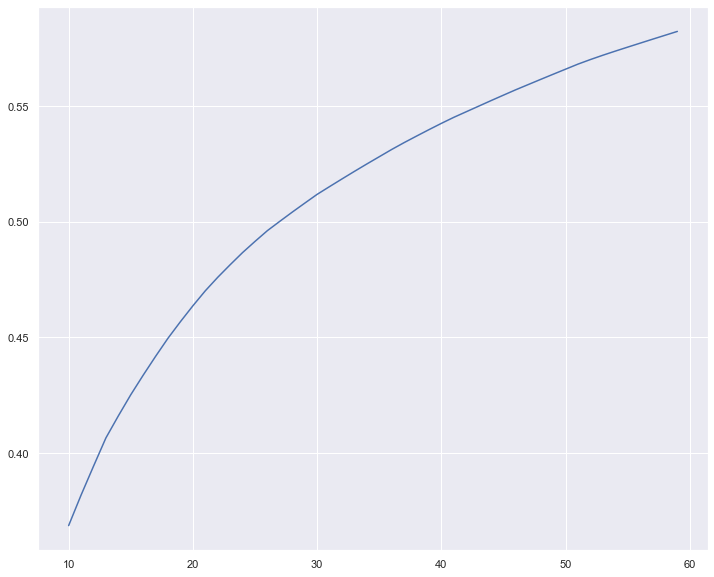

In [85]:
fractions = [sum(map(lambda x: x[1], counter.most_common(n))) / sum(counter.values()) for n in range(10, 60)]
sns.lineplot(range(10, 60), fractions)

<AxesSubplot:>

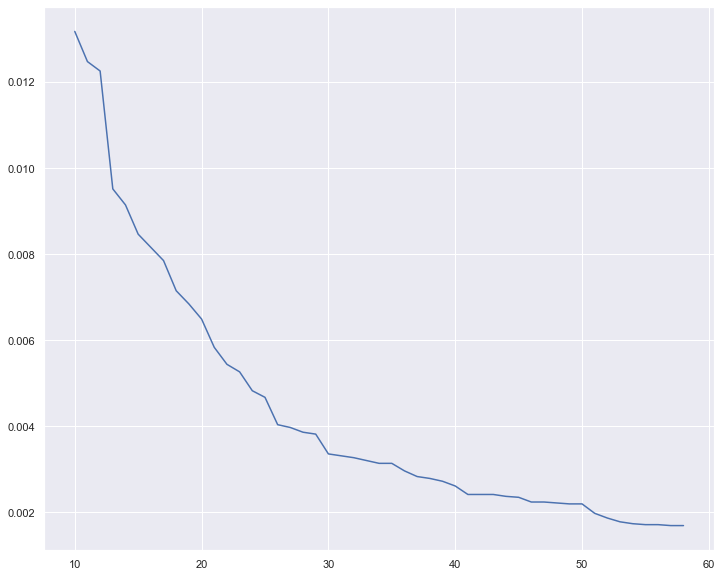

In [87]:
diffs = np.array(fractions)[1:] - np.array(fractions)[:-1]
sns.lineplot(range(10, 59), diffs)

Sources seem like a useful feature. There is too many unique websites to use all of them (the model will likely overfit). Using an elbow method we see that 30 most common sources is the optimal amount.

## subjects

In [106]:
all_subjects = reduce(lambda x, y: x+y.split(','), train_df['subjects'], [])

In [115]:
all_subjects = list(map(lambda x: x.strip(), all_subjects))

In [116]:
subj_counter = Counter(all_subjects)

In [117]:
subj_counter.most_common(50)

[('', 2824),
 ('Health', 1361),
 ('Health News', 1242),
 ('General News', 952),
 ('Politics', 657),
 ('National', 479),
 ('Environment', 473),
 ('Health Care', 471),
 ('Fact Checks', 385),
 ('Coronavirus', 365),
 ('U.S. News', 348),
 ('Public Health', 341),
 ('AP Top News', 323),
 ('Science', 289),
 ('Medical', 278),
 ('Texas', 238),
 ('Viral Content', 234),
 ('Florida', 221),
 ('Business', 215),
 ('Crime', 214),
 ('Public health', 205),
 ('Facebook Fact-checks', 203),
 ('North America', 196),
 ('Donald Trump', 190),
 ('Wisconsin', 188),
 ('International News', 185),
 ('Virus Outbreak', 184),
 ('Facebook posts', 168),
 ('Junk News', 167),
 ('COVID-19', 166),
 ('PunditFact', 161),
 ('Abortion', 153),
 ('Cancer', 150),
 ('Entertainment', 132),
 ('Georgia', 131),
 ('Europe', 127),
 ('Disinformation', 119),
 ('Science News', 116),
 ('Fauxtography', 111),
 ('Mental health', 109),
 ('Guns', 109),
 ('New York', 105),
 ('Marijuana', 104),
 ('Africa', 104),
 ('Education', 98),
 ('Immigration', 

D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

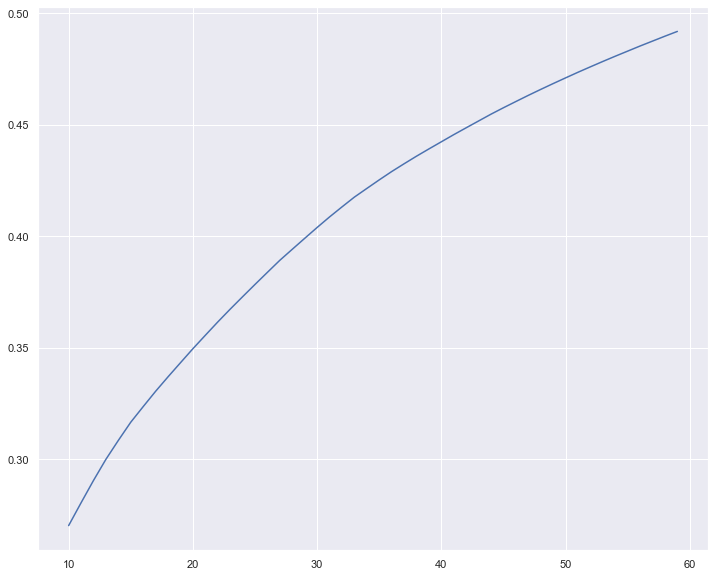

In [118]:
subj_fractions = [sum(map(lambda x: x[1], subj_counter.most_common(n))) / sum(subj_counter.values()) for n in range(10, 60)]
sns.lineplot(range(10, 60), subj_fractions)

D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

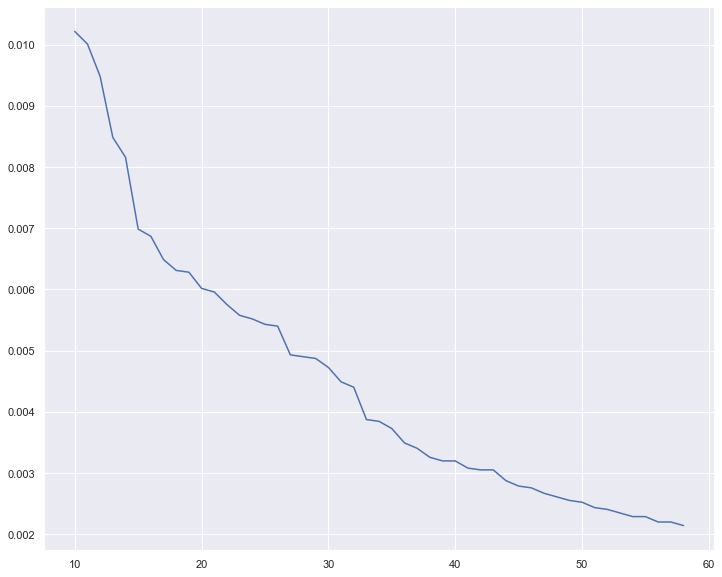

In [119]:
diffs = np.array(subj_fractions)[1:] - np.array(subj_fractions)[:-1]
sns.lineplot(range(10, 59), diffs)

Similarly to sources, elbow method show that 33 is a optimal cutoff value